In [1]:
import tensorflow as tf

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Check the shape of the data
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


This is a data driven study of grouping tasks with 5 tasks added


In [6]:

# Convert to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)

# Define CIFAR-10 classes
cifar10_classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 1. Living Being
living_beings = {'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse'}
y_living = np.isin(y_train.flatten(), [cifar10_classes.index(cls) for cls in living_beings]).astype(int)

# 2. Odd-numbered classes and odd indices
odd_classes = {'Automobile', 'Cat', 'Dog', 'Horse', 'Truck'}
odd_class_indices = [cifar10_classes.index(cls) for cls in odd_classes]
y_odd = np.array([(label in odd_class_indices) and (i % 2 == 1) for i, label in enumerate(y_train.flatten())]).astype(int)

# 3. Downside task (flipping half the images)
# Flipping half of the images upside down
indices_to_flip = np.random.choice(x_train.shape[0], x_train.shape[0] // 2, replace=False)
x_train_new = x_train.copy()
for index in indices_to_flip:
    x_train_new[index] = np.flipud(x_train_new[index])

y_downside = np.zeros(x_train.shape[0])
y_downside[indices_to_flip] = 1

# 4. Not Living Being
not_living_beings = {'Airplane', 'Automobile', 'Ship', 'Truck'}
y_not_living = np.isin(y_train.flatten(), [cifar10_classes.index(cls) for cls in not_living_beings]).astype(int)

# 5. Random task
np.random.seed(42)  # For reproducibility
y_random = np.random.randint(2, size=x_train.shape[0])

# Concatenate the new labels with the original y_train_one_hot
new_labels = np.stack([y_living, y_odd, y_downside, y_not_living, y_random], axis=1)
y_train_extended = np.concatenate([y_train_one_hot, new_labels], axis=1)



# Check the shapes and new labels
print("Extended training labels shape:", y_train_extended.shape)
print("Flipped images included in training data")


# Check shapes of the combined dataset and labels
print("Combined training data shape:", x_train_new.shape)
print("Extended combined training labels shape:", y_train_extended.shape)

# Use x_train_combined for training images (includes both original and flipped images)
# Use y_train_extended_combined for extended labels (includes original CIFAR-10 labels and new binary class labels)


Extended training labels shape: (50000, 15)
Flipped images included in training data
Combined training data shape: (50000, 32, 32, 3)
Extended combined training labels shape: (50000, 15)


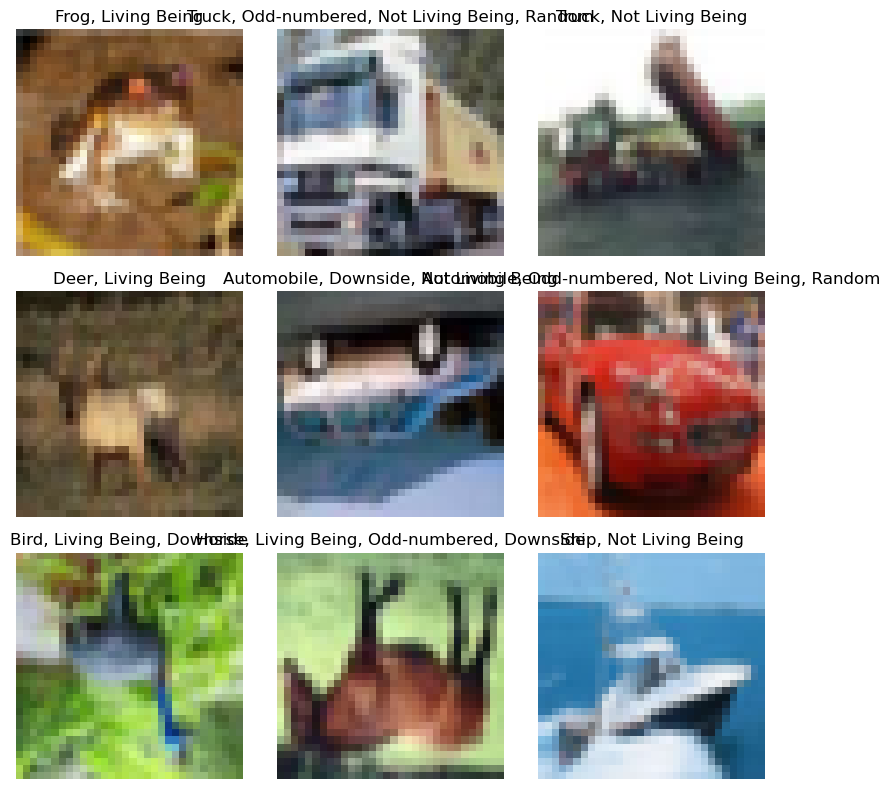

In [7]:
import matplotlib.pyplot as plt


class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck','Living Being', 'Odd-numbered', 'Downside', 'Not Living Being', 'Random']

# Function to plot images with labels
def plot_images(images, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        
        # Finding active labels and constructing title
        active_labels = [class_names[i] for i, lbl in enumerate(label) if lbl == 1]
        title = ', '.join(active_labels)
        
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few images to display
plot_images(x_train_new[:9], y_train_extended[:9])

In [8]:
y_train_extended[y_train_extended == 0] = -1

We look at the correlation matrix of the tasks to see how good a predictore it is of the pairing discovered in \grouping2023

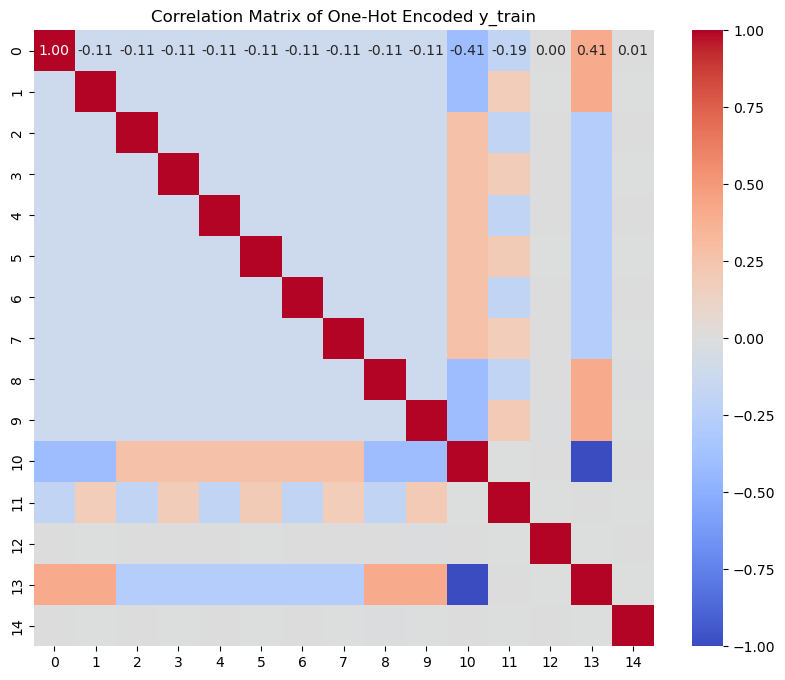

In [9]:

import seaborn as sns


# Calculate the correlation matrix
correlation_matrix = np.corrcoef(y_train_extended, rowvar=False)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of One-Hot Encoded y_train")
plt.show()


We can observe:
1. As in G1 no information from target correlation about correla between cats and birds or cats and cars
2. As can be expected correl between living being and some specific living being are visible
3. row 11 shows the spurious correl between odd and living

In [20]:
"""We adapt the functions from grouping1 
so that they can handle any number n of binary tasks

subset has been modified to generate the subsets of at most max_size
"""
from itertools import combinations
import numpy as np
import random

class TopologicalFunctions:
    def __init__(self, n=15):
        """
        Initialize the TopologicalFunctions class 
        """
        self.n = n

    def validate_array(self, U):
        if len(U) != self.n:
            raise ValueError(f"Input array U must be of length {self.n}.")
        if not all(x in [0, 1] for x in U):
            raise ValueError("Input array U must only contain 0s and 1s.")

    def subsets(self, U, max_size=2, max_n=300):
        self.validate_array(U)

        if max_size > sum(U):
            raise ValueError("U must be bigger than min_size")

        subsets = []
        for i in range(1, 2 ** self.n):
            candidate = [(i >> bit) & 1 for bit in range(self.n)]
            if all(candidate[k] <= U[k] for k in range(self.n)) and sum(candidate) <= max_size:
                subsets.append(np.array(candidate))
        
        if max_n < len(subsets):
            return random.sample(subsets, max_n)
        else:
            return subsets

    def filtrationk(self, U, k):
        self.validate_array(U)

        if not (0 <= k <= self.n):
            raise ValueError(f"k must be an integer between 0 and {self.n}.")

        filtration = []
        for i in range(1, 2 ** self.n):
            candidate = [(i >> bit) & 1 for bit in range(self.n)]
            differences = sum(candidate[i] != U[i] for i in range(self.n) if U[i] == 1)
            if differences <= k and not all(candidate[i] == U[i] for i in range(self.n)) and all(candidate[i] == 0 if U[i] == 0 else True for i in range(self.n)):
                filtration.append(np.array(candidate))

        return filtration


In [15]:
def generate_arrays_list(k, n=15):
    result_list = []
    for num_ones in range(k+1):  # 0 to k inclusive
        for indices in combinations(range(n), num_ones):
            array = np.zeros(n, dtype=int)
            array[list(indices)] = 1
            result_list.append(array)
    return result_list


In [46]:

import networkx as nx
class DatabaseOperations:
    def __init__(self, x, y, n=15, class_names=class_names):
        # ... [existing initialization code] ...

          
        """
        Initialize the DatabaseOperations class with a data matrix x, label matrix y, and an integer j indicating a class of interest.

        Args:
        x (numpy.ndarray): A n-dimensional array representing the data.
        y (numpy.ndarray): A 2-dimensional array with the same size in dim 0 as x, representing labels.
        
        """
        if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
            raise ValueError("x and y must be numpy arrays.")

        if x.shape[0] != y.shape[0]:
            raise ValueError("x and y must have the same size in the first dimension.")

        
        self.n = n  # length of the array
        self.x = x
        self.y = y
        self.filtration_function = TopologicalFunctions().filtrationk
        self.topo_funcs = TopologicalFunctions().subsets
        self.gen_set = generate_arrays_list
        self.class_names = class_names
        

    def indicesV(self, V):
        # Check the length of V
        if len(V) != self.n:
            raise ValueError(f"V must be an {self.n}-element array.")

        
        # Create a boolean mask based on V and y
        mask = np.any(self.y[:, V == 1] == 1, axis=1)

        return mask
    
    def SigmaXy(self, index):
        """
        Filters rows of x using the provided boolean index array and calculates 1/x'.shape[0] * y^T * x',
        where x' is the filtered x. Flattens and unflattens x if it has more than 2 dimensions.

        Args:
        index (numpy.ndarray): A boolean array indicating the subset of rows to consider.

        Returns:
        numpy.ndarray: The calculated value of 1/x'.shape[0] * y[:,j]^T * x', unflattened to its original shape if needed.
        """
        if not isinstance(index, np.ndarray) :
            raise ValueError("index must be a numpy boolean array.")

        if len(index) != self.x.shape[0]:
            raise ValueError("index must be of the same length as the number of rows in x.")

        # Flatten x if it has more than 2 dimensions
        original_shape = self.x.shape
        if len(original_shape) > 2:
            x_flattened = self.x.reshape(original_shape[0], -1)
        else:
            x_flattened = self.x
        
        # Filter x and y based on the index
        x_filtered = x_flattened[index]
        y_filtered = self.y[index, :]  

        # Calculate the result
        if x_filtered.shape[0] == 0:
            return np.zeros(original_shape[1:])  # To handle division by zero

        result = np.dot(y_filtered.T, x_filtered) / x_filtered.shape[0]

        # Reshape the result to match the original shape of x, if it was flattened
        if len(original_shape) > 2:
            result = result.reshape((self.y.shape[1],) + original_shape[1:])

        return result
    
    

    def Incon_k_U(self, U, k, phi = None, dist_meas = None):
        """
        Computes incon_k_U for a given U and k. Generates listV = filtration_function(U, k).
        For each V in listV, computes the pair (dist, U-V), where dist is the Euclidean distance
        between SigmaXy(U) and SigmaXy(V).

        Args:
        U (numpy.ndarray): A n-element array of 0s and 1s.
        k (int): The degree of filtration to consider.
        filtration_function (function): A function to generate the Lambda_k filtration of U.

        Returns:
        list: A list of pairs (dist, U-V).
        numpy.ndarray: A n-element array indicating for which value of U-V the dist was maximum.
        """
        listV = self.filtration_function(U, k)

        results = []
        max_dist = 0
        max_diff = np.zeros(self.n)
        U_ind = self.indicesV(U)

        if phi == None:
            sigmaXy_U = self.SigmaXy(U_ind)
        else:
            sigmaXy_U = phi(U_ind)

        for V in listV:
            V_ind = self.indicesV(V)

            if phi == None:
                sigmaXy_V = self.SigmaXy(V_ind)
            else:
                sigmaXy_V = phi(V_ind)

            rows = sigmaXy_U.shape[0]
            sigma_U_mat = sigmaXy_U.reshape(rows,-1)
            sigma_V_mat = sigmaXy_V.reshape(rows,-1)
            if dist_meas == None:

                dist = np.linalg.norm(sigma_U_mat - sigma_V_mat,"fro")
            else:
                dist = dist_meas(sigma_U_mat, sigma_V_mat)
            diff = U - V
            results.append((dist, diff))

            if dist > max_dist:
                max_dist = dist
                max_diff = diff

        return results, max_diff, max_dist

    def Incon_k_U_pair(self, U, k, phi = None, dist_meas = None):
        """
        Computes incon_k_U for a given U and k. Generates listV = filtration_function(U, k).
        For each V in listV, computes the pair (dist, U-V), where dist is the Euclidean distance
        between SigmaXy(U) and SigmaXy(V).

        Args:
        U (numpy.ndarray): A n-element array of 0s and 1s.
        k (int): The degree of filtration to consider.
        filtration_function (function): A function to generate the Lambda_k filtration of U.

        Returns:
        list: A list of pairs (dist, U-V).
        numpy.ndarray: A n-element array indicating for which value of U-V the dist was maximum.
        """
        listV = self.filtration_function(U, k)

        results = []
        max_dist = 0
        max_diff = np.zeros(self.n)
        U_ind = self.indicesV(U)

        if phi == None:
            sigmaXy_U = self.SigmaXy(U_ind)
        else:
            sigmaXy_U = phi(U_ind)

        for V in listV:
            V_ind = self.indicesV(V)

            if phi == None:
                sigmaXy_V = self.SigmaXy(V_ind)
            else:
                sigmaXy_V = phi(V_ind)

            rows = sigmaXy_U.shape[0]
            sigma_U_mat = sigmaXy_U.reshape(rows,-1)
            sigma_V_mat = sigmaXy_V.reshape(rows,-1)
            if dist_meas == None:

                dist = np.linalg.norm(sigma_U_mat - sigma_V_mat,"fro")
            else:
                dist = dist_meas(sigma_U_mat, sigma_V_mat)
            diff = U - V
            results.append((dist, diff, V))

            if dist > max_dist:
                max_dist = dist
                max_diff = diff

        return results, max_diff, max_dist

    
    def multiIncon_k_U(self, U, k, phi=None, dist_meas_list=None):
        """
        Computes multiIncon_k_U for a given U and k with multiple distance measurement functions. 
        Generates listV = filtration_function(U, k).
        For each V in listV, and each distance measurement function in dist_meas_list, 
        computes the pair (dist, U-V), where dist is the distance between SigmaXy(U) and SigmaXy(V)
        measured by the distance function.

        Args:
        U (numpy.ndarray): A n-element array of 0s and 1s.
        k (int): The degree of filtration to consider.
        phi (function): Optional transformation function for U and V indices.
        dist_meas_list (list of functions): A list of distance measurement functions.

        Returns:
        dict: A dictionary where keys are the names of functions in dist_meas_list and 
            values are triplets (results, max_diff, max_dist) computed for each function.
        """
        listV = self.filtration_function(U, k)
        U_ind = self.indicesV(U)
        sigmaXy_U = phi(U_ind) if phi else self.SigmaXy(U_ind)

        # Dictionary to store results for each distance measurement function
        all_results = {}

        for dist_meas in dist_meas_list:
            results = []
            max_dist = 0
            max_diff = np.zeros(self.n)

            for V in listV:
                V_ind = self.indicesV(V)
                sigmaXy_V = phi(V_ind) if phi else self.SigmaXy(V_ind)

                rows = sigmaXy_U.shape[0]
                sigma_U_mat = sigmaXy_U.reshape(rows, -1)
                sigma_V_mat = sigmaXy_V.reshape(rows, -1)

                dist = dist_meas(sigma_U_mat, sigma_V_mat) if dist_meas else np.linalg.norm(sigma_U_mat - sigma_V_mat, "fro")
                diff = U - V
                results.append((dist, diff))

                if dist > max_dist:
                    max_dist = dist
                    max_diff = diff

            # Store the results for the current distance measurement function
            function_name = dist_meas.__name__ if dist_meas else 'default'
            all_results[function_name] = (results, max_diff, max_dist)

        return all_results

    def incon_k(self, k, max_size=2, phi = None, dist_meas = None):
        # Generate the set S of all n-arrays of 0s and 1s
        I = np.ones(self.n, dtype=int)
        S = self.topo_funcs(I, max_size)

        # Dictionary to keep track of the number of times each V is associated with the max distance
        S_k= self.gen_set(k)
        max_dist_count = {tuple(V): 0 for V in S_k}
        max_dist = {tuple(V): 0 for V in S_k}
        mean_discrep_l = {tuple(V): [] for V in S_k}
        mean_discrep = {tuple(V): 0 for V in S_k}
        # Iterate over each V in S
        print("S",S)
        for V in S:
            list_tup, max_diff, max_dis = self.Incon_k_U(V, k, phi, dist_meas)
            print(list_tup, max_diff,max_dis)
            max_diff_tuple = tuple(max_diff)
            max_dist_count[max_diff_tuple]+=1
            max_dist[max_diff_tuple]=max(max_dist[max_diff_tuple],max_dis)
            for tup in list_tup:
                mean_discrep_l[tuple(tup[1])].append(tup[0])
        mean_discrep = {key: (sum(value) / len(value)) if len(value) != 0 else 0 for key, value in mean_discrep_l.items()}
        return max_dist_count, max_dist, mean_discrep

    def incon_k_pairs(self, k, max_size=2, phi = None, dist_meas = None):
        # Generate the set S of all n-arrays of 0s and 1s
        I = np.ones(self.n, dtype=int)
        S = self.topo_funcs(I, max_size)
        M= np.zeros((self.n, self.n))
        # Dictionary to keep track of the number of times each V is associated with the max distance
        S_k= self.gen_set(k)
        max_dist_count = {tuple(V): 0 for V in S_k}
        max_dist = {tuple(V): 0 for V in S_k}
        mean_discrep_l = {tuple(V): [] for V in S_k}
        mean_discrep = {tuple(V): 0 for V in S_k}
        # Iterate over each V in S
        print("S",S)
        for V in S:
            list_tup, _, _ = self.Incon_k_U_pair(V, k, phi, dist_meas)
            
            for tup in list_tup:
                M[np.where(tup[1] == 1)[0],np.where(tup[2] == 1)[0]]=tup[0]
        
        return M    

        
    def multiIncon_k(self, k, max_size=2, phi=None, dist_meas_list=None):
        """
        Computes incon_k for a given k with multiple distance measurement functions. 
        Returns a dictionary where keys are the names of functions in dist_meas_list and 
        values are the outputs of incon_k computed with each respective function.

        Args:
        k (int): The degree of filtration to consider.
        min_size (int): Minimum size to consider in topo_funcs.
        phi (function): Optional transformation function for indices.
        dist_meas_list (list of functions): A list of distance measurement functions.

        Returns:
        dict: A dictionary where keys are the names of functions in dist_meas_list and 
            values are the outputs of incon_k computed for each function.
        """
        # Generate the set S of all 10-arrays of 0s and 1s
        I = np.ones(self.n, dtype=int)
        S = self.topo_funcs(I, max_size)

        # Initialize dictionary for results
        all_results = {}

        # Process each distance measurement function
        for dist_meas in dist_meas_list:
            S_k = self.gen_set(k)
            max_dist_count = {tuple(V): 0 for V in S_k}
            max_dist = {tuple(V): 0 for V in S_k}
            mean_discrep_l = {tuple(V): [] for V in S_k}

            # Iterate over each V in S
            for V in S:
                list_tup, max_diff, max_dis = self.multiIncon_k_U(V, k, phi, [dist_meas])[dist_meas.__name__]

                max_diff_tuple = tuple(max_diff)
                max_dist_count[max_diff_tuple] += 1
                max_dist[max_diff_tuple] = max(max_dist[max_diff_tuple], max_dis)

                for dist, diff in list_tup:
                    mean_discrep_l[tuple(diff)].append(dist)

            # Compute mean discrepancy
            mean_discrep = {key: (sum(value) / len(value)) if value else 0 for key, value in mean_discrep_l.items()}
            
            # Store the results for the current distance measurement function
            function_name = dist_meas.__name__
            all_results[function_name] = (max_dist_count, max_dist, mean_discrep)

        return all_results


    def multiIncon_k2(self, k, max_size=2, phi=None, dist_meas_list=None):
        """
        Optimized version of multiIncon_k which calls multiIncon_k_U only once for each V in S
        with all the distance measurement functions in dist_meas_list. Computes incon_k for each
        function and returns a dictionary of results.

        Args:
        k (int): The degree of filtration to consider.
        min_size (int): Minimum size to consider in topo_funcs.
        phi (function): Optional transformation function for indices.
        dist_meas_list (list of functions): A list of distance measurement functions.

        Returns:
        dict: A dictionary where keys are the names of functions in dist_meas_list and 
            values are the outputs of incon_k computed for each function.
        """
        # Generate the set S of all 10-arrays of 0s and 1s
        I = np.ones(self.n, dtype=int)
        S = self.topo_funcs(I, max_size)

        # Dictionary to store results for each distance measurement function
        all_results = {dist_meas.__name__: {'max_dist_count': {}, 'max_dist': {}, 'mean_discrep_l': {}} for dist_meas in dist_meas_list}

        # Process each V in S
        for V in S:
            multi_results = self.multiIncon_k_U(V, k, phi, dist_meas_list)

            for dist_meas in dist_meas_list:
                function_name = dist_meas.__name__
                list_tup, max_diff, max_dis = multi_results[function_name]

                # Convert max_diff to a tuple
                max_diff_tuple = tuple(max_diff)

                # Ensure the key exists in the dictionaries, initialize if not
                for result_dict in [all_results[function_name]['max_dist_count'],
                                    all_results[function_name]['max_dist']]:
                    if max_diff_tuple not in result_dict:
                        result_dict[max_diff_tuple] = 0

                all_results[function_name]['max_dist_count'][max_diff_tuple] += 1
                all_results[function_name]['max_dist'][max_diff_tuple] = max(all_results[function_name]['max_dist'][max_diff_tuple], max_dis)

                for dist, diff in list_tup:
                    diff_tuple = tuple(diff)

                    # Ensure the key exists in the mean_discrep_l dictionary
                    if diff_tuple not in all_results[function_name]['mean_discrep_l']:
                        all_results[function_name]['mean_discrep_l'][diff_tuple] = []

                    all_results[function_name]['mean_discrep_l'][diff_tuple].append(dist)

        # Compute mean discrepancy for each function
        # ... [rest of your function code] ...


            # Compute mean discrepancy for each function
        for function_name in all_results:
            mean_discrep = {key: (sum(value) / len(value)) if value else 0 for key, value in all_results[function_name]['mean_discrep_l'].items()}
            all_results[function_name]["mean_discrep_l"] = mean_discrep
            #all_results[function_name] = (all_results[function_name]['max_dist_count'], all_results[function_name]['max_dist'], mean_discrep)

        return all_results
    def compute_sigma_by_class(self, class_names):
        """
        Compute the SigmaXy value for each class and return a dictionary with class names as keys.

        Args:
        class_names (list of str): List of class names corresponding to each of the n positions.

        Returns:
        dict: Dictionary with class names as keys and SigmaXy values as values.
        """
        if len(class_names) != self.n:
            raise ValueError("class_names must have 10 elements.")

        sigma_dict = {}
        for i in range(self.n):
            # Create an array with one 1 at position i and 0s elsewhere
            V = np.zeros(self.n, dtype=int)
            V[i] = 1

            # Calculate the index
            index = self.indicesV(V)

            # Compute SigmaXy for this index
            sigma_value = self.SigmaXy(index)

            # Store in dictionary with class name as key
            sigma_dict[class_names[i]] = sigma_value

        return sigma_dict
    
    def create_frobenius_graph(self):
        """
        Create a graph where each vertex is a class name, and edges represent the Frobenius distances 
        between the matrices corresponding to the vertices.
        """
        # Assuming class_names is a class attribute or can be obtained somehow
        sigma_values = self.compute_sigma_by_class(self.class_names)

        # Create a graph
        G = nx.Graph()

        # Add nodes
        for class_name in self.class_names:
            G.add_node(class_name)

        # Add edges with Frobenius distances
        for i, class_name1 in enumerate(self.class_names):
            for j, class_name2 in enumerate(self.class_names):
                if i < j:  # To avoid duplicate edges and self-loops
                    distance = np.linalg.norm(sigma_values[class_name1] - sigma_values[class_name2])
                    G.add_edge(class_name1, class_name2, weight=distance)

        # Draw and display the graph
        self._draw_graph(G)

    def _draw_graph(self, G):
        """
        Draw and display a graph G using matplotlib, interpreting edge weights as distances.

        Args:
        G (networkx.Graph): A NetworkX graph object.
        """
        plt.figure(figsize=(10, 8))

        # Use the spring layout with weights, interpreting them as distances
        pos = nx.spring_layout(G, weight='weight')

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)

        # Draw edges
        nx.draw_networkx_edges(G, pos, width=2)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

        plt.title("Graph with Edge Weights as Distances")
        plt.axis('off')
        plt.show()


In [18]:
'''7 dist_meas functions for svd decompositions'''
from scipy.linalg import subspace_angles
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
'''This function will compute the Euclidean distance between the singular value vectors 
of two matrices.'''
def svd_singular_value_difference(A, B):
    singular_values_A = np.linalg.svd(A, compute_uv=False)
    singular_values_B = np.linalg.svd(B, compute_uv=False)
    return np.linalg.norm(singular_values_A - singular_values_B)

'''This function will compute the principal angles between the subspaces spanned by
 the left singular vectors of two matrices and return the sum of cosine of these 
 angles.'''
def subspace_angle_distance(A, B):
    U_A, _, _ = np.linalg.svd(A, full_matrices=False)
    U_B, _, _ = np.linalg.svd(B, full_matrices=False)
    angles = subspace_angles(U_A, U_B)
    return np.sum(np.cos(angles))

'''This function will measure how closely the subspaces spanned by 
the singular vectors of one matrix can be made to align with those of the other.'''
def procrustes_distance(A, B):
    U_A, _, _ = np.linalg.svd(A, full_matrices=False)
    U_B, _, _ = np.linalg.svd(B, full_matrices=False)
    R, scale = orthogonal_procrustes(U_A, U_B)
    return np.linalg.norm(U_A @ R - U_B)

'''This function computes the Frobenius norm
 of the difference between low-rank approximations of two matrices.'''
def frobenius_norm_difference_approximations(A, B):
    k=2
    U_A, s_A, Vt_A = np.linalg.svd(A, full_matrices=False)
    U_B, s_B, Vt_B = np.linalg.svd(B, full_matrices=False)
    A_k = np.dot(U_A[:, :k], np.dot(np.diag(s_A[:k]), Vt_A[:k, :]))
    B_k = np.dot(U_B[:, :k], np.dot(np.diag(s_B[:k]), Vt_B[:k, :]))
    return np.linalg.norm(A_k - B_k, 'fro')

'''This function computes the cosine similarity between 
the singular vectors of two matrices.'''
def cosine_similarity_singular_vectors(A, B):
    _, _, Vt_A = np.linalg.svd(A, full_matrices=False)
    _, _, Vt_B = np.linalg.svd(B, full_matrices=False)
    cos_sim = np.dot(Vt_A.flatten(), Vt_B.flatten()) / (np.linalg.norm(Vt_A) * np.linalg.norm(Vt_B))
    return cos_sim


'''This function computes the Jensen-Shannon divergence between the normalized
 singular values of two matrices.'''
def jensen_shannon_divergence(A, B):
    singular_values_A = np.linalg.svd(A, compute_uv=False)
    singular_values_B = np.linalg.svd(B, compute_uv=False)
    normalized_A = singular_values_A / np.sum(singular_values_A)
    normalized_B = singular_values_B / np.sum(singular_values_B)
    return jensenshannon(normalized_A, normalized_B)

'''This function computes the Earth Mover’s Distance between the distributions
 of singular values of two matrices.'''
def earth_movers_distance(A, B):
    singular_values_A = np.linalg.svd(A, compute_uv=False)
    singular_values_B = np.linalg.svd(B, compute_uv=False)
    return wasserstein_distance(singular_values_A, singular_values_B)




In [47]:
db = DatabaseOperations(x_train_new,y_train_extended)

In [45]:
db.Incon_k_U_pair(np.array([1,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),k=1,dist_meas=svd_singular_value_difference)

([(26.299354618554514,
   array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
  (8.74570354176131,
   array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))],
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 26.299354618554514)

In [49]:
M=db.incon_k_pairs(k=1)

S [array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 0, 0, 1, 

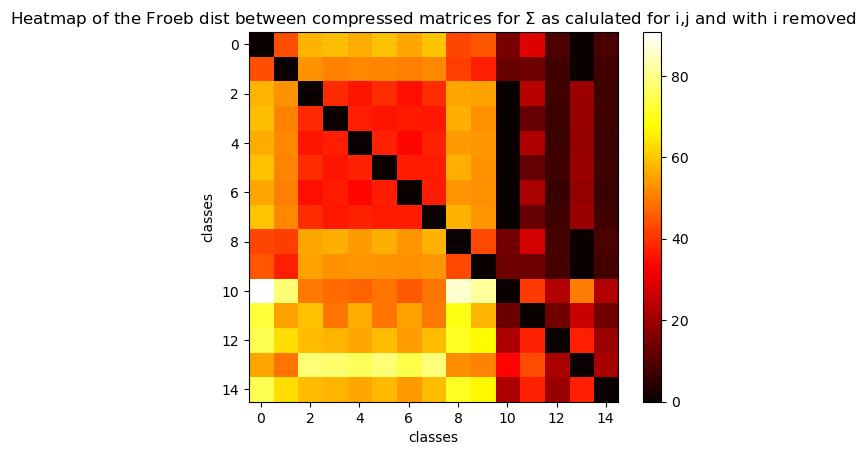

In [51]:
plt.imshow(M, cmap='hot', interpolation='nearest')

# Adding color bar
plt.colorbar()

# Adding titles and labels (optional)
plt.title('Heatmap of the Froeb dist between compressed matrices for $\Sigma$ as calulated for i,j and with i removed')
plt.xlabel('classes')
plt.ylabel('classes')

# Show the plot
plt.show()

A more significant map is the symmetrized one

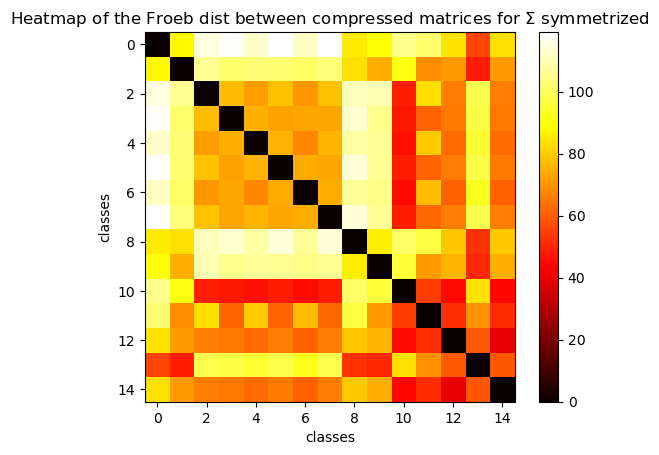

In [52]:
plt.imshow(M+M.T, cmap='hot', interpolation='nearest')

# Adding color bar
plt.colorbar()

# Adding titles and labels (optional)
plt.title('Heatmap of the Froeb dist between compressed matrices for $\Sigma$ symmetrized')
plt.xlabel('classes')
plt.ylabel('classes')

# Show the plot
plt.show()

The darker, the highest the similarity between tasks. Some positive findings are:
1 The links coming from targets correlations are very visible, for instance between ling being and any particular living being category.
2 The links between any pair of living cat or any pair of non living are also clearly visible and interestingly of very similar amplitudes. These could not have been deduced from the targets correlation matrix.
Some limitations are:
1 Random is more similar to sme tasks than others (which is fully due to imbalances)
2 The similarity between living (row 10) and odd (row 11) and flipped (row 12) is typically what we expect to be caused by imbalances